In [10]:
import sys
sys.path.append("..")
import utils.saver as saver
import matplotlib.pyplot as plt
import numpy as np

import system.tunable_full_cosine as system
import utils.solver as s
import utils.expectation_values as expv


# Setup Experimental Data

In [42]:
experimental_data = saver.load_via_pickle("mingkang_data_0.15")

In [43]:
experimental_freqs = experimental_data["freqArray"]
experimental_fids = experimental_data["I_rot.T"]
experimental_time = experimental_data["timeArray"]
experimental_data.keys()

dict_keys(['freqArray', 'ssbArray', 'timeArray', 'Q_rot.T', 'I_rot.T'])

In [44]:
len(experimental_freqs)

91

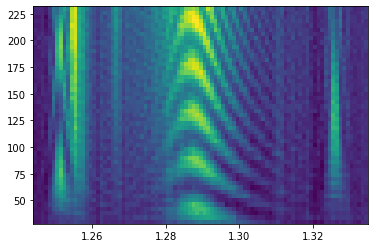

In [45]:
plt.pcolormesh(experimental_freqs, experimental_time, experimental_fids, shading='auto')

In [51]:
# rescale data to 0-1 scale for fidelity
# normalized_experimental_fids = ((experimental_fids - np.amin(experimental_fids)) / np.amax(experimental_fids))
normalized_experimental_fids = ((experimental_fids - np.amin(experimental_fids)))
normalized_experimental_fids /= np.amax(normalized_experimental_fids)

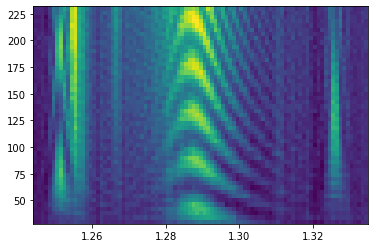

In [52]:
plt.pcolormesh(experimental_freqs, experimental_time, normalized_experimental_fids, shading='auto')
# cool still works

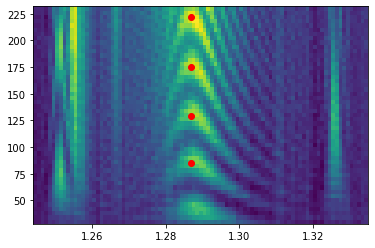

In [70]:
# pick some points to be representative
# we only need to scan over very narrow range around center to get where the chevrons are
freq_points = [1.287, 1.287, 1.287, 1.287]
dur_points = [85, 129, 175, 222]
plt.pcolormesh(experimental_freqs, experimental_time, normalized_experimental_fids, shading='auto')
plt.scatter(freq_points, dur_points, color='red')

# Run Simulations

In [ ]:
def run_sim(amplitude):
    